In [1]:
import os
import errno
import numpy as np

import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import callbacks

import deepcell
from deepcell import model_zoo
from deepcell import losses
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler
from deepcell.utils.tracking_utils import load_trks
from deepcell.utils.tracking_utils import save_trks
from deepcell.utils.retinanet_anchor_utils import get_anchor_parameters
from deepcell.callbacks import RedirectModel, Evaluate
from deepcell.image_generators import RetinaMovieDataGenerator, RetinaNetGenerator
# from deepcell.model_zoo import shapemask_box

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Helper Functions
From `shape_mask` branch

In [2]:
def train_model(model,
                model_dir=None,
                model_name=None,
                train_dict=None,
                test_dict=None,
                batch_size=1,
                num_classes=1,
                fpb=1,
                backbone_levels=None,
                pyramid_levels=None,
                anchor_params=None,
                n_epoch=16,
                optimizer=Adam(lr=1e-5, clipnorm=0.001),
                lr_sched = rate_scheduler(lr=1e-5, decay=0.99)
                ):
    
    if fpb == 1:
        datagen = RetinaNetGenerator(
            rotation_range=180,
            zoom_range=(0.8, 1.2),
            horizontal_flip=True,
            vertical_flip=True)

        datagen_val = RetinaNetGenerator()

        train_data = datagen.flow(
            train_dict,
            batch_size=batch_size,
            include_masks=True,
            include_final_detection_layer=True,
            pyramid_levels=pyramid_levels,
            anchor_params=anchor_params)

        val_data = datagen_val.flow(
            test_dict,
            batch_size=batch_size,
            include_masks=True,
            include_final_detection_layer=True,
            pyramid_levels=pyramid_levels,
            anchor_params=anchor_params)
    
    else:
        datagen = RetinaMovieDataGenerator(
            rotation_range=180,
            zoom_range=(0.8, 1.2),
            horizontal_flip=True,
            vertical_flip=True)

        datagen_val = RetinaMovieDataGenerator()

        train_data = datagen.flow(
            train_dict,
            batch_size=batch_size,
            include_masks=True,
            include_final_detection_layer=True,
            frames_per_batch=fpb,
            pyramid_levels=pyramid_levels,
            anchor_params=anchor_params)

        val_data = datagen_val.flow(
            test_dict,
            batch_size=batch_size,
            include_masks=True,
            include_final_detection_layer=True,
            frames_per_batch=fpb,
            pyramid_levels=pyramid_levels,
            anchor_params=anchor_params)

    retinanet_losses = losses.RetinaNetLosses(
        sigma=3.0,
        alpha=0.25,
        gamma=2.0,
        iou_threshold=0.5,
        mask_size=(28,28))

    loss = {
        'regression': retinanet_losses.regress_loss,
        'classification': retinanet_losses.classification_loss,
        'masks': retinanet_losses.mask_loss,
        'final_detection': retinanet_losses.final_detection_loss
        }

    model.compile(loss=loss, optimizer=optimizer)

    iou_threshold = 0.5
    score_threshold = 0.01
    max_detections = 100

    model.fit_generator(
        train_data,
        steps_per_epoch=X_train.shape[0] * X_train.shape[1]// batch_size,
        epochs=n_epoch,
        validation_data=val_data,
        validation_steps=X_test.shape[0] * X_test.shape[1]// batch_size,
        callbacks=[
            callbacks.LearningRateScheduler(lr_sched),
            callbacks.ModelCheckpoint(
                os.path.join(model_dir, model_name + '.h5'),
                monitor='val_loss',
                verbose=1,
                save_best_only=True,
                save_weights_only=False),
            RedirectModel(
                Evaluate(val_data,
                         iou_threshold=iou_threshold,
                         score_threshold=score_threshold,
                         max_detections=max_detections,
                         frames_per_batch=fpb,
                         weighted_average=True),
                prediction_model)
        ])

    return None

# Train models

In [ ]:
# download_datasets()

DATA_DIR = '/data/training_data/tracking_benchmark_data'

backbones = ['mobilenetv2']
fpbs = [5, 3, 1]
all_data = '3T3_HeLa_HEK_RAW_cropped.npz'
datasets = [all_data]
temporal_modes = ['conv', 'gru', 'lstm', None]
shape_mask = False

n_epoch = 4
seed = 808


for dataset in datasets:
    num_classes=1
    test_size = 0.1 # % of data saved as test
    test_seed = 10

    filename = os.path.join(DATA_DIR, dataset)
    train_dict, test_dict = get_data(filename, seed=seed, test_size=test_size)
    print(' -\nX.shape: {}\ny.shape: {}'.format(train_dict['X'].shape, train_dict['y'].shape))
    X_train, y_train = train_dict['X'], train_dict['y']
    X_test, y_test = test_dict['X'], test_dict['y']
    y_train_reshaped = y_train.reshape((-1,  X_train.shape[2], X_train.shape[3], X_train.shape[4]))
    print("y_train_reshaped shape:", y_train_reshaped.shape)
    optimal_params = get_anchor_parameters(y_train.reshape((-1,  X_train.shape[2], X_train.shape[3], X_train.shape[4])))
    backbone_levels, pyramid_levels, anchor_params = optimal_params
    norm_method='whole_image'
    print("optimal_params: ", optimal_params)

    for backbone in backbones:
        if backbone == 'featurenet':
            use_imagenet=False
        else:
            use_imagenet=True

        for fpb in fpbs:
            if fpb == 1:
                train_dict = {'X':X_train.reshape((-1,X_train.shape[2], X_train.shape[3], X_train.shape[4])), 
                              'y': y_train.reshape((-1,y_train.shape[2], y_train.shape[3], y_train.shape[4]))}
                test_dict = {'X':X_test.reshape((-1, X_test.shape[2], X_test.shape[3], X_test.shape[4])), 
                            'y': y_test.reshape((-1, y_test.shape[2], y_test.shape[3], y_test.shape[4]))}
            else:
                train_dict = {'X':X_train, 'y':y_train}
                test_dict = {'X':X_test, 'y':y_test}
            print(' -\nX.shape: {}\ny.shape: {}'.format(train_dict['X'].shape, train_dict['y'].shape))


            for temporal_mode in temporal_modes:
                model = model_zoo.RetinaMask(backbone=backbone,
                                        use_imagenet=use_imagenet,
                                        panoptic=False,
                                        frames_per_batch=fpb,
                                        temporal_mode=temporal_mode,
                                        num_classes=num_classes,
                                        input_shape=X_train.shape[2:],
                                        anchor_params=anchor_params,
                                        class_specific_filter=False,
                                        backbone_levels=backbone_levels,
                                        pyramid_levels=pyramid_levels,
                                        norm_method=norm_method)
                prediction_model = model

                model_dir = '/data/models'
                model_name = backbone + '_' + 'fpb' + str(fpb) + '_' + str(temporal_mode) + '_' + dataset

                # Train model
                print("Training model: ", model_name)
                trained_model = train_model(model,
                            model_dir=model_dir,
                            model_name=model_name,
                            train_dict=train_dict,
                            test_dict=test_dict,
                            fpb=fpb,
                            backbone_levels=backbone_levels,
                            pyramid_levels=pyramid_levels,
                            anchor_params=anchor_params,
                            n_epoch=n_epoch,
                          )


# Benchmark

In [3]:
# Define data to load (raw images from trk test files)
RAW_BASE_DIR = '/data/training_data/tracking_benchmark_data/test'

raw_trks_3T3  = os.path.join(RAW_BASE_DIR, '3T3_NIH_test_BData.trks')
raw_trks_HEK  = os.path.join(RAW_BASE_DIR, 'HEK293_generic_test_BData.trks')
raw_trks_HeLa = os.path.join(RAW_BASE_DIR, 'HeLa_S3_test_BData.trks')
raw_trks_RAW  = os.path.join(RAW_BASE_DIR, 'RAW264_generic_test_BData.trks')

# raw_trks_files = [raw_trks_3T3, raw_trks_HEK, raw_trks_HeLa]
raw_trks_files = [raw_trks_3T3, raw_trks_HEK, raw_trks_RAW, raw_trks_HeLa]

model_dir = '/data/models'

DATA_DIR = '/data/training_data/tracking_benchmark_data'
dataset = '3T3_HeLa_HEK_RAW_cropped.npz'
filename = os.path.join(DATA_DIR, dataset)
test_size = 0.1 # % of data saved as test
seed = 808
train_dict, test_dict = get_data(filename, seed=seed, test_size=test_size)
X_train, y_train = train_dict['X'], train_dict['y']

In [45]:
from skimage.segmentation import relabel_sequential
from skimage.measure import label, regionprops
from skimage.transform import resize


def retinanet_to_label_image(retinanet_outputs,
                             shape0,
                             shape1,
                             include_final_detection_layer=False,
                             score_threshold=0.5,
                             multi_iou_threshold=0.25,
                             binarize_threshold=0.5,
                             small_objects_threshold=100):

    if include_final_detection_layer:
        boxes_batch = retinanet_outputs[-5][0]
        scores_batch = retinanet_outputs[-4][0]
        labels_batch = retinanet_outputs[-3][0]
        masks_batch = retinanet_outputs[-2][0]
        final_scores = retinanet_outputs[-1][0]
    else:
        boxes_batch = retinanet_outputs[-4][0]
        scores_batch = retinanet_outputs[-3][0]
        labels_batch = retinanet_outputs[-2][0]
        masks_batch = retinanet_outputs[-1][0]
        
    # Create empty label matrix
    label_images = np.zeros(
        (masks_batch.shape[0], shape0, shape1))

    # Iterate over batches
    for i in range(boxes_batch.shape[0]):
        boxes = boxes_batch[i]
        scores = scores_batch[i]
        labels = labels_batch[i]
        masks = masks_batch[i]
        
        # Get good detections
        selection = np.nonzero(scores > score_threshold)[0]
        boxes = boxes[selection]
        scores = scores[selection]
        labels = labels[selection]
        masks = masks[selection, ..., -1]

        # Compute overlap of masks with each other
        mask_image = np.zeros((masks.shape[0], shape0, shape1), dtype='float32')

        for j in range(masks.shape[0]): # masks.shape[0] = fpb
            mask = masks[j]
            box = boxes[j].astype(int)
            mask = resize(mask, (box[3] - box[1], box[2] - box[0]))
            mask = (mask > binarize_threshold).astype('float32')
            mask_image[j, box[1]:box[3], box[0]:box[2]] = mask
            
        all_masks = mask_image
        range_mask = np.arange(1, all_masks.shape[0] + 1)
        all_masks *= np.expand_dims(np.expand_dims(range_mask, axis=-1), axis=-1)

        label_image = np.sum(all_masks, axis=0).astype(int)

        # Remove small objects
        label_image = morphology.remove_small_objects(
            label_image, min_size=small_objects_threshold)

        # Relabel the label image
        label_image, _, _ = relabel_sequential(label_image)

        # Store in batched array
        label_images[i] = label_image

    return label_images

In [ ]:
# Make predictions on test data
from deepcell.utils.tracking_utils import load_trks
from deepcell.utils.retinanet_anchor_utils import evaluate

from skimage.morphology import remove_small_objects
import pandas as pd
from deepcell import metrics
from skimage.measure import label
from skimage import morphology
from skimage.morphology import watershed
from skimage.feature import peak_local_max


iou_threshold = 0.5
score_threshold = 0.01
max_detections = 100
num_classes=1

backbones = ['mobilenetv2', 'featurenet', 'resnet50']
fpbs = [5, 3]

temporal_modes = ['conv', 'gru', 'lstm', None]
shape_mask = False
training_optimal_params = get_anchor_parameters(y_train.reshape((-1,  X_train.shape[2], X_train.shape[3], X_train.shape[4])))

# Go through each Dataset (3T3, HEK293, HeLa, RAW264.7)
for set_num, dataset in enumerate(raw_trks_files):
    print("dataset: ", dataset)
    # Load the trk file       
    trks = load_trks(dataset)
    lineages, raw, tracked = trks['lineages'], trks['X'], trks['y']
    norm_method='whole_image'
    backbone_levels, pyramid_levels, anchor_params = training_optimal_params
    datagen_val = RetinaMovieDataGenerator()
    
    for backbone in backbones:
        if backbone == 'featurenet':
                use_imagenet=False
        else:
            use_imagenet=True
                
        for fpb in fpbs:
            print("frames per batch: ", fpb)
            for temporal_mode in temporal_modes:
                prediction_model = model_zoo.RetinaMask(backbone=backbone,
                                        use_imagenet=use_imagenet,
                                        panoptic=False,
                                        frames_per_batch=fpb,
                                        temporal_mode=temporal_mode,
                                        num_classes=num_classes,
                                        input_shape=trks['X'].shape[2:],
                                        anchor_params=anchor_params,
                                        class_specific_filter=False,
                                        backbone_levels=backbone_levels,
                                        pyramid_levels=pyramid_levels,
                                        norm_method=norm_method)
                # print(prediction_model.summary())

                model_dir = '/data/models/'
                model_name = backbone + '_' + 'fpb' + str(fpb) + '_' + str(temporal_mode) + '_' + '3T3_HeLa_HEK_RAW_cropped.npz'
                print(backbone + '_' + 'fpb' + str(fpb) + '_' + str(temporal_mode))
                prediction_model.load_weights(os.path.join(model_dir, model_name + '.h5'))

                Model_DF = pd.DataFrame(columns=['total_instances', 'mAP'])
                
                Lstats_allmovies = []

                # Go through each batch (movie) in each dataset
                for batch_num, movie in enumerate(trks['X']):
                    Lstats = []
                    print("batch_num: ", batch_num)

                    # Predict on the raw data
                    X_test_temp = np.expand_dims(movie, axis=0)
                    y_test_temp = np.expand_dims(trks['y'][batch_num], axis=0)
                    y_pred = np.zeros(y_test_temp.shape)
                    
                    for index in range(X_test_temp.shape[0]):
                        for frame in range(0, X_test_temp.shape[0], fpb):
                            image = X_test_temp[index:index + 1, frame:frame + fpb]
                            gt_mask = y_test_temp[index:index + 1, frame:frame + fpb]
                            outputs = prediction_model.predict(image)
                            label_images = retinanet_to_label_image(outputs, X_test_temp.shape[2], 
                                               X_test_temp.shape[3], include_final_detection_layer=True)
                            
                            for i in range(fpb):
                                GT_image = y_test_temp[index, frame+i, :, :, 0]
                                GT_image = np.expand_dims(GT_image, axis=0)
                                pred = label_images[i]
                                pred = np.expand_dims(pred, axis=0)
                                m = metrics.Metrics(model_name = model_name)
                                m.calc_object_stats(GT_image, pred)
                                Lstats.append(m.stats)
                                
                            y_pred[index, frame:frame + fpb,...,0] = np.array(label_images)
                            
                    Lstats_allmovies.append(Lstats)
                df = pd.concat([pd.concat(Lstats_allmovies[i]) for i in range(len(Lstats_allmovies))])
                df.to_csv(os.getcwd() + '/' + backbone + '_' + \
                          'fpb' + str(fpb) + '_' + str(temporal_mode) + '.csv', index=False)
                print('\n')
                print(backbone + '_' + 'fpb' + str(fpb) + '_' + str(temporal_mode))
                print('\n')
                # Total number of correct detections and incorrect detections
                correct_det = int(df['correct_detections'].sum())
                incorrect_det = int(df['n_pred'].sum() - df['correct_detections'].sum())

                print('Correct Detections: ', correct_det)
                print('Incorrect Detections: ', incorrect_det)

                # Total number of splits, merges, and catastrophes
                splits = df['split'].sum()
                merges = df['merge'].sum()
                catastrophes = df['catastrophe'].sum()

                print('Splits: ', splits)
                print('Merges: ', merges)
                print('Catastrophes: ', catastrophes)

                # Average Recall, Precision, and Jaccard Index
                recall = 100 * df['correct_detections'].sum() / df['n_true'].sum()
                precision = 100 * df['correct_detections'].sum() / df['n_pred'].sum()
                jaccard = df['jaccard'].mean()

                print('Recall: ', recall)
                print('Precision: ', precision)
                print('Average Jaccard Index: ', jaccard)
            

dataset:  /data/training_data/tracking_benchmark_data/test/3T3_NIH_test_BData.trks
frames per batch:  5


# Display data

In [43]:
from skimage.segmentation import relabel_sequential
from skimage.measure import label, regionprops
from skimage.transform import resize


def retinanet_to_label_image(retinanet_outputs,
                             shape0,
                             shape1,
                             include_final_detection_layer=False,
                             score_threshold=0.5,
                             multi_iou_threshold=0.25,
                             binarize_threshold=0.5,
                             small_objects_threshold=100):

    if include_final_detection_layer:
        boxes_batch = retinanet_outputs[-5][0]
        scores_batch = retinanet_outputs[-4][0]
        labels_batch = retinanet_outputs[-3][0]
        masks_batch = retinanet_outputs[-2][0]
        final_scores = retinanet_outputs[-1][0]
    else:
        boxes_batch = retinanet_outputs[-4][0]
        scores_batch = retinanet_outputs[-3][0]
        labels_batch = retinanet_outputs[-2][0]
        masks_batch = retinanet_outputs[-1][0]
        
    # Create empty label matrix
    label_images = np.zeros(
        (masks_batch.shape[0], shape0, shape1))

    # Iterate over batches
    for i in range(boxes_batch.shape[0]):
        boxes = boxes_batch[i]
        scores = scores_batch[i]
        labels = labels_batch[i]
        masks = masks_batch[i]
        
        # Get good detections
        selection = np.nonzero(scores > score_threshold)[0]
        boxes = boxes[selection]
        scores = scores[selection]
        labels = labels[selection]
        masks = masks[selection, ..., -1]

        # Compute overlap of masks with each other
        mask_image = np.zeros((masks.shape[0], shape0, shape1), dtype='float32')

        for j in range(masks.shape[0]): # masks.shape[0] = fpb
            mask = masks[j]
            box = boxes[j].astype(int)
            mask = resize(mask, (box[3] - box[1], box[2] - box[0]))
            mask = (mask > binarize_threshold).astype('float32')
            mask_image[j, box[1]:box[3], box[0]:box[2]] = mask
            
        all_masks = mask_image
        range_mask = np.arange(1, all_masks.shape[0] + 1)
        all_masks *= np.expand_dims(np.expand_dims(range_mask, axis=-1), axis=-1)

        label_image = np.sum(all_masks, axis=0).astype(int)

        # Remove small objects
        label_image = morphology.remove_small_objects(
            label_image, min_size=small_objects_threshold)

        # Relabel the label image
        label_image, _, _ = relabel_sequential(label_image)

        # Store in batched array
        label_images[i] = label_image

    return label_images

(5, 100, 4)
(5, 100)
(5, 100)
(5, 100, 28, 28, 1)


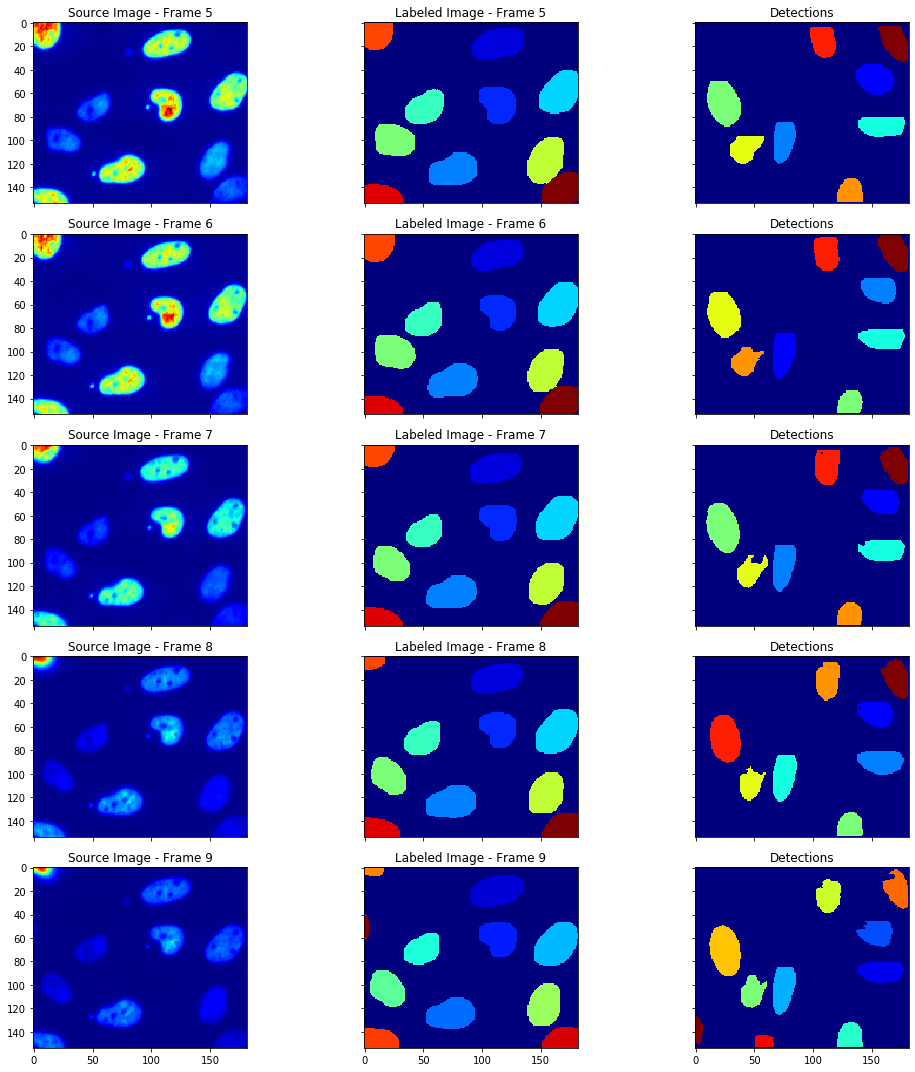

In [44]:
import matplotlib.pyplot as plt

from deepcell.utils.plot_utils import draw_detections

frame = 5
index = 0
image = X_test_temp[index:index + 1, frame:frame + fpb]
gt_mask = y_test_temp[index:index + 1, frame:frame + fpb]

# outputs = prediction_model.predict(image)
boxes = outputs[-5]
scores = outputs[-4]
labels = outputs[-3]
masks = outputs[-2]
final_scores = outputs[-1]

display = 0.01 * np.tile(np.expand_dims(image[0, ..., 0], axis=-1), (1, 1, 3))
gt_mask = np.squeeze(gt_mask)

label_images = retinanet_to_label_image(outputs, X_test_temp.shape[2], 
                                               X_test_temp.shape[3], include_final_detection_layer=True)

fig, axes = plt.subplots(ncols=3, nrows=fpb, figsize=(15, 15), sharex=True, sharey=True)
for i in range(fpb):
    axes[i, 0].imshow(display[i, ..., 0], cmap='jet')
    axes[i, 0].set_title('Source Image - Frame {}'.format(frame + i))

    axes[i, 1].imshow(gt_mask[i], cmap='jet')
    axes[i, 1].set_title('Labeled Image - Frame {}'.format(frame + i))

    axes[i, 2].imshow(label_images[i], cmap='jet')
    axes[i, 2].set_title('Detections')

fig.tight_layout()
plt.show()

fig.tight_layout()
plt.show()

In [29]:
plt.imshow(mask_image[0])

IndexError: index 0 is out of bounds for axis 0 with size 0

In [20]:
boxes = outputs[-5]
scores = outputs[-4]
labels = outputs[-3]
masks = outputs[-2]
print(boxes.shape)
print(scores.shape)
print(labels.shape)
print(masks.shape)

(1, 5, 100, 4)
(1, 5, 100)
(1, 5, 100)
(1, 5, 100, 28, 28, 1)


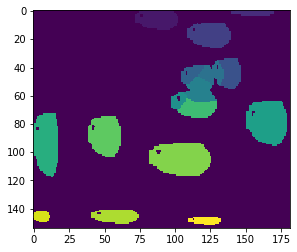

In [71]:
plt.imshow(watershed_images)

In [160]:
image.shape

(1, 3, 216, 256, 1)

In [114]:
draw_list[0].shape

(154, 182, 3)

In [115]:
index

0

In [148]:
df = pd.concat([pd.concat(Lstats_allmovies[i]) for i in range(len(Lstats_allmovies))])
print('\n')
print(backbone + '_' + 'fpb' + str(fpb) + '_' + str(temporal_mode))
print('\n')
# Total number of correct detections and incorrect detections
correct_det = int(df['correct_detections'].sum())
incorrect_det = int(df['n_pred'].sum() - df['correct_detections'].sum())

print('Correct Detections: ', correct_det)
print('Incorrect Detections: ', incorrect_det)

# Total number of splits, merges, and catastrophes
splits = df['split'].sum()
merges = df['merge'].sum()
catastrophes = df['catastrophe'].sum()

print('Splits: ', splits)
print('Merges: ', merges)
print('Catastrophes: ', catastrophes)

# Average Recall, Precision, and Jaccard Index
recall = 100 * df['correct_detections'].sum() / df['n_true'].sum()
precision = 100 * df['correct_detections'].sum() / df['n_pred'].sum()
jaccard = df['jaccard'].mean()

print('Recall: ', recall)
print('Precision: ', precision)
print('Average Jaccard Index: ', jaccard)



mobilenetv2_fpb5_conv


Correct Detections:  581
Incorrect Detections:  458
Splits:  13
Merges:  7
Catastrophes:  12
Recall:  52.060931899641574
Precision:  55.91915303176131
Average Jaccard Index:  0.6212300672022402


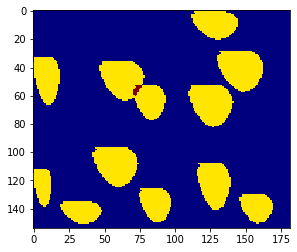

In [135]:
pred = y_pred[-1, -1, :, :, 0]
plt.imshow(draw_list[-1][...,0], cmap='jet')

In [150]:
os.getcwd()

'/notebooks/deepcell/notebooks'